In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, kendalltau
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Load your data (with VADER and RoBERTa columns)
data = pd.read_csv('stratifiedSentimentData\socialMedia_with_advanced_sentiment.csv')


C:\Users\cassi\AppData\Local\Temp\ipykernel_31056\2851823803.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('stratifiedSentimentData\socialMedia_with_advanced_sentiment.csv')


In [3]:
# --- Score Preparation ---
# VADER (already in [-1, 1])
data['vader_score'] = data['vader_compound']

# RoBERTa: Convert labels to numeric and preserve confidence
roberta_map = {'LABEL_0': -1, 'LABEL_1': 0, 'LABEL_2': 1}
data['roberta_numeric'] = data['roberta_label'].map(roberta_map)

# NEW: Adjusted RoBERTa scoring (neutral scores centered at 0 with magnitude)
data['roberta_adjusted'] = np.where(
    data['roberta_label'] == 'LABEL_1',  # Neutral
    data['roberta_score'] * 0.5 - 0.25,  # Map [0,1] to [-0.25,0.25]
    data['roberta_score'] * data['roberta_numeric']  # Positive/Negative keep weighted
)

In [4]:
# --- Statistical Tests ---
# Pearson correlation (continuous)
pearson_corr, pearson_p = pearsonr(data['vader_score'], data['roberta_adjusted'])

# Kendall's tau (ordinal agreement)
kendall_corr, kendall_p = kendalltau(data['vader_score'], data['roberta_numeric'])

print(f"Pearson Correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Kendall's Tau: {kendall_corr:.3f} (p-value: {kendall_p:.3f})")

Pearson Correlation: 0.678 (p-value: 0.000)
Kendall's Tau: 0.538 (p-value: 0.000)


In [5]:
# Agreement percentage (sign match, excluding neutrals)
non_neutral = data[data['roberta_label'] != 'LABEL_1']
agreement = np.mean(
    np.sign(non_neutral['vader_score']) == np.sign(non_neutral['roberta_numeric'])
) * 100
print(f"Sign Agreement (Non-Neutral Only): {agreement:.1f}%")

Sign Agreement (Non-Neutral Only): 80.6%


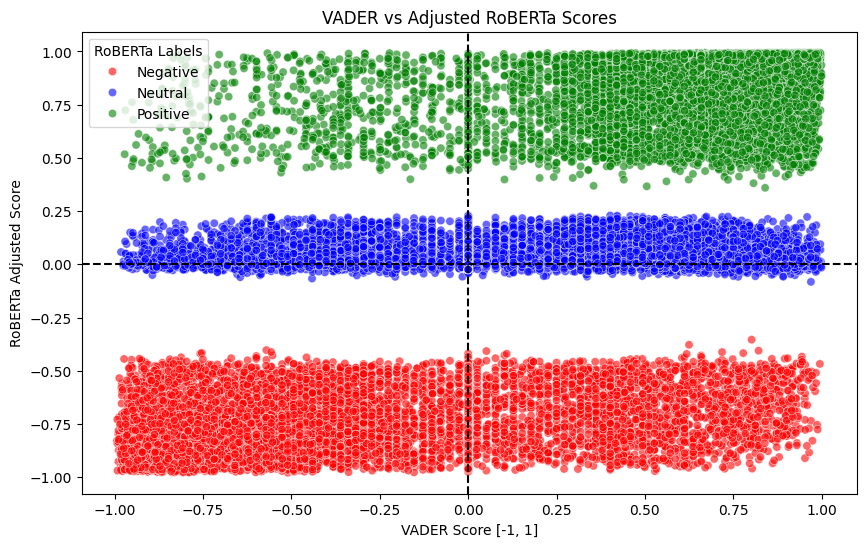

In [6]:
# 1. Scatter plot with neutral zone
plt.figure(figsize=(10, 6))

# Define the correct label mapping and color palette
legend_labels = {'LABEL_0': 'Negative', 'LABEL_1': 'Neutral', 'LABEL_2': 'Positive'}
palette = {'LABEL_0': 'red', 'LABEL_1': 'blue', 'LABEL_2': 'green'}

# Plot with explicit hue_order to enforce the correct order
scatter = sns.scatterplot(
    data=data,
    x='vader_score',
    y='roberta_adjusted',
    hue='roberta_label',
    hue_order=['LABEL_0', 'LABEL_1', 'LABEL_2'],  # Explicit order
    palette=palette,
    alpha=0.6
)

# Get the current legend handles and labels
handles, labels = scatter.get_legend_handles_labels()

# Replace the labels with the human-readable versions
new_labels = [legend_labels[label] for label in labels]

# Recreate the legend with the correct labels
plt.legend(
    handles=handles,
    labels=new_labels,
    title='RoBERTa Labels'
)

plt.axhline(y=0, color='black', linestyle='--')
plt.axvline(x=0, color='black', linestyle='--')
plt.title("VADER vs Adjusted RoBERTa Scores")
plt.xlabel("VADER Score [-1, 1]")
plt.ylabel("RoBERTa Adjusted Score")
plt.show()

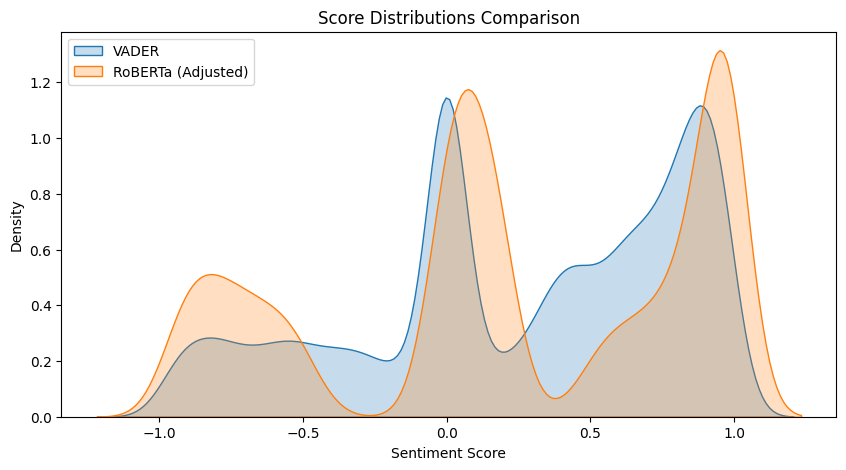

In [7]:
# 2. Distribution comparison
plt.figure(figsize=(10, 5))
sns.kdeplot(data=data, x='vader_score', label='VADER', fill=True)
sns.kdeplot(data=data, x='roberta_adjusted', label='RoBERTa (Adjusted)', fill=True)
plt.title("Score Distributions Comparison")
plt.xlabel("Sentiment Score")
plt.legend()
plt.show()

In [8]:
# Find texts where VADER and RoBERTa disagree most
data['abs_diff'] = abs(data['vader_score'] - data['roberta_adjusted'])
disagreements = data.sort_values('abs_diff', ascending=False).head(10)

print("\nTop Disagreements:")
for idx, row in disagreements.iterrows():
    print(f"\nText: {row['attributes.search_data_fields.all_text'][:200]}...")
    print(f"VADER: {row['vader_score']:.2f}")
    print(f"RoBERTa: {row['roberta_adjusted']:.2f} ({row['roberta_label']}, raw score={row['roberta_score']:.2f})")
    print(f"Absolute Difference: {row['abs_diff']:.2f}")



Top Disagreements:

Text: @delta is participating in union busting activities. From retaliation to holding "pizza and ice cream parties" when  workers are planning a picket line, Delta is blocking union organzing in the workpl...
VADER: 0.95
RoBERTa: -0.91 (LABEL_0, raw score=0.91)
Absolute Difference: 1.86

Text: @KanekoaTheGreat When the big money not only moves away, but very publicly lashes Biden like this… you know there’s serious, serious, trouble

You can tell this guy REALLY isn’t pleased about this. Ev...
VADER: 0.96
RoBERTa: -0.88 (LABEL_0, raw score=0.88)
Absolute Difference: 1.85

Text: Dina Titus supports free housing, free medical, free education, free food, free phones and free pass for people who break our laws to enter our country. It’s time for Titus and her failed policies to ...
VADER: 0.96
RoBERTa: -0.85 (LABEL_0, raw score=0.85)
Absolute Difference: 1.81

Text: RT @TONYxTWO: This is absolutely incredible 🔥🔥🔥 @realDonaldTrump 

Spotted in Port Lavaca, Texas 🇺🇸 htt